# Working out imports and reading files

### Imports

In [49]:
import os
import pandas as pd

### Geting sensor file names

In [50]:
files = [file for file in os.listdir('../../Processed Sensors')]
files.sort()

### Reading sensor files

In [51]:
read_files = []
for file in files:
    read_files.append(pd.read_csv('../../Processed Sensors/' + file))

### Get each file's columns in a list of lists

In [52]:
cols_file = [read_files[i].columns.tolist() for i in range(len(read_files))]

### Draw out all the common sensors, since the data is not consistent we need to look at sensors that consistently appear

In [53]:
from functools import reduce
common_els = reduce(set.intersection, (set(item) for item in cols_file))
common_els = list(common_els)

### Applying the sensor filters

In [54]:
read_files = [read_files[i][common_els] for i in range(len(read_files))]

# Working on labelization

### Reading and removing unecessary data from the failure excel

In [55]:
downtimeNew = pd.read_excel('../../Raw Data/Equipment downtime data (202310).xlsx')

In [56]:
downtimeNew['FaultDate'] = pd.to_datetime(downtimeNew['FaultDate'], errors='coerce').dt.date
downtimeNew['FaultTime'] = downtimeNew['FaultTime'].apply(lambda x: x.strftime('%H:%M:%S') if len(str(x)) > 8 else x)
downtimeNew = downtimeNew.dropna(subset=['FaultDate', 'FaultTime'])
pattern_new = downtimeNew.iloc[:, :14]
pattern_new = pattern_new.drop(['ID', 'DutyOfficer', 'Manager email address'], axis=1)
pattern_new['FaultDateTime'] = pd.to_datetime(pattern_new['FaultDate'].astype(str) + ' ' + pattern_new['FaultTime'].astype(str))
pattern_new.drop(['FaultDate', 'FaultTime'], axis=1, inplace=True)
pattern_new.sort_values(by=['FaultDateTime'], inplace=True)
pattern_new = pattern_new.drop(['LogEntry', 'DutyOfficer comments', 'Managerscomments', 'FaultRepair', 'FaultDescription', 'Group', 'Downtime'], axis=1)
pattern_new['Equipment'] = pattern_new['Equipment'].str.lower()
pattern_new['Equipment'] = pattern_new['Equipment'].str.replace('[^\w\s]', '', regex=True)
pattern_new = pattern_new[pattern_new['Equipment'] == 'ion source']

### Sorting them by user run and labeling the minutes where ion source failed with 1

In [57]:
userruns = ['18/04', '19/01', '19/02', '19/03', '20/01', '20/02', '20/03', '21/01', '21/02', '22/01', '22/02', '22/03', '22/04', '22/05', '23/01', '23/02', '23/03']

In [58]:
isrcFailRuns = [pattern_new[pattern_new['User Run'] == ur] for ur in userruns]

In [59]:
for i in range(len(read_files)):
    read_files[i]['Label'] = 0
    read_files[i]['Time'] = pd.to_datetime(read_files[i]['Time'], format='%d/%m/%Y, %H:%M:%S')
    for j in range(read_files[i].shape[0]-1):
        for el in isrcFailRuns[i]['FaultDateTime']:
            if read_files[i]['Time'][j] <= el < read_files[i]['Time'][j+1]:
                read_files[i].loc[j, 'Label'] = 1   #['Label'][j] = 1
                break

In [60]:
print(sum(read_files[14]['Label']), sum(read_files[15]['Label']), sum(read_files[16]['Label']))

8 11 11


### Expanding timewindow, make it X minutes before the failure

In [61]:
twindow = 20

In [62]:
for i in range(len(read_files)):
    for j in range(read_files[i].shape[0]):
        if read_files[i]['Label'][j] == 1:
            for k in range(twindow):
                if j-k-1 < 0:
                    break
                read_files[i].loc[j-k-1, 'Label'] = 1

### Skipping correlation for now as it is for experimenting stage

In [63]:
kbSensors = [
    'Time',
    'irfq::mag:read_volts',
    'irfq::gas:back_press',
    'irfq::mag:read_current',
    'irfq::arc_dc:read_current',
    'irfq::arc_pulser_on:sta',
    'irfq::gas:read_press',
    'irfq::ion_source:sta',
    'irfq::arc_dc:set_current',
    'irfq::h2_gas:read_flow',
    'irfq::arc_ac:read_current',
    'irfq::gas:on',
    'irfq::arc_remote:sta',
    'irfq::arc_dc_on:sta',
    'irfq::arc_dc:on',
    'irfq::arc_dc:read_volts',
    'irfq::platform:read_volts',
    'irfq::isrce_line:read_press',
    'irfq::ext:set_volts',
    'irfq::mag_on:sta',
    'irfq::arc_ac:set_current',
    'irfq::ext:read_current',
    'irfq::arc_pulser_intlk:sta',
    'irfq::ext:read_volts',
    'irfq::gas:set_press',
    'Label'
]

In [64]:
rfNew = read_files.copy()

In [65]:
rfNew = [rfNew[i][kbSensors] for i in range(len(rfNew))]

### Setting up the training and testing sets

In [66]:
X_train = pd.concat(rfNew[:14])
X_test = pd.concat(rfNew[14:])

In [67]:
y_train = X_train['Label']
y_test = X_test['Label']

X_train.drop(['Label', 'Time'], axis=1, inplace=True)
X_test.drop(['Label', 'Time'], axis=1, inplace=True)

### Conduct Experiment

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    criterion='entropy',
    n_jobs=-1
    )
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[144813      0]
 [   630      0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    144813
           1       0.00      0.00      0.00       630

    accuracy                           1.00    145443
   macro avg       0.50      0.50      0.50    145443
weighted avg       0.99      1.00      0.99    145443



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

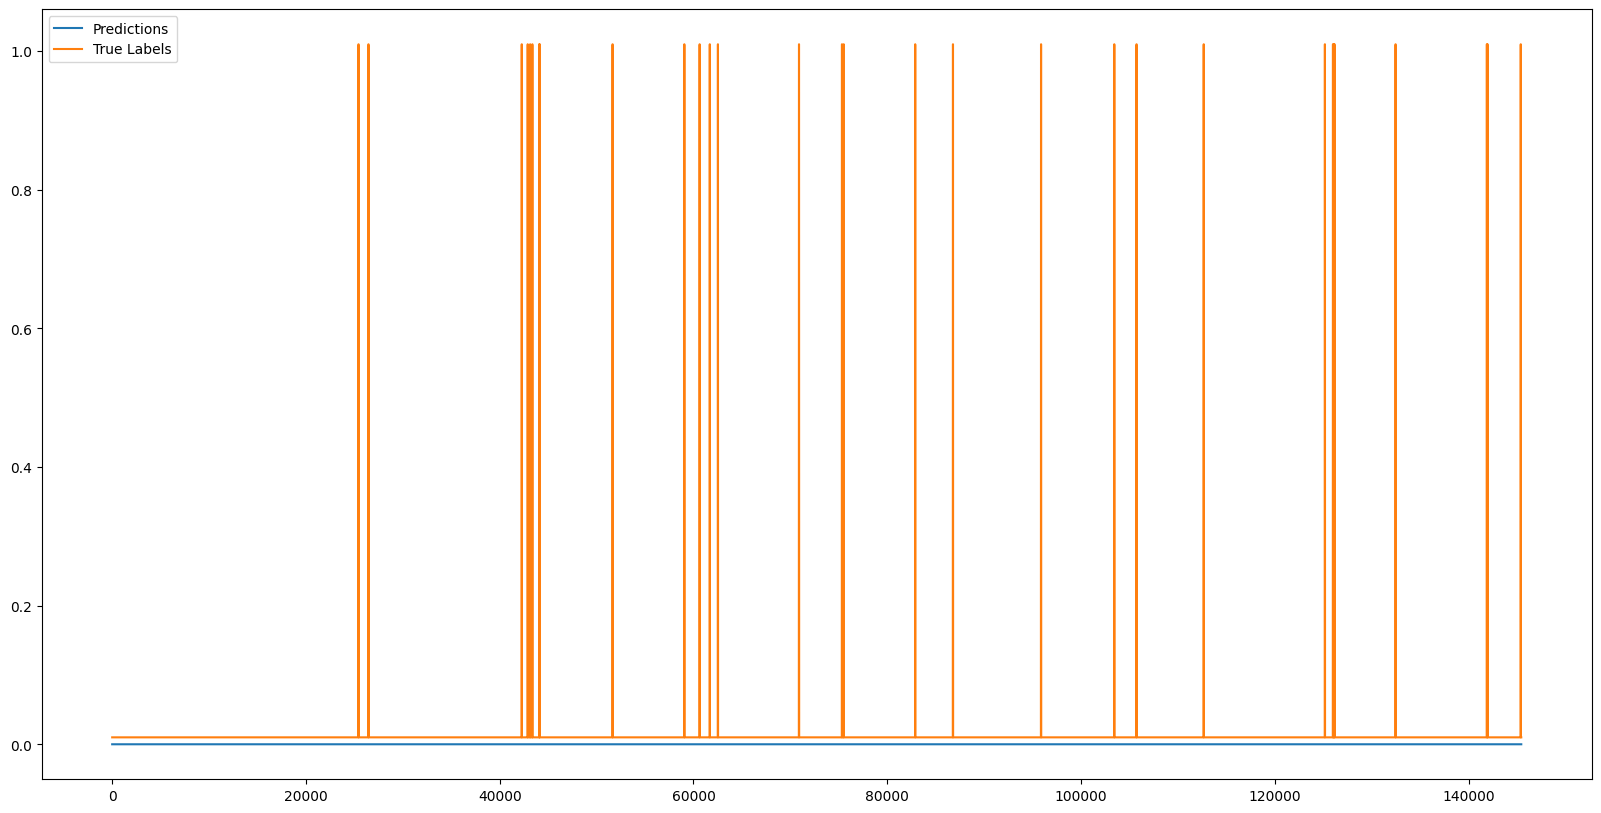

In [69]:
plott = y_test.to_list()
plott = [i+0.01 for i in plott]
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(y_pred, label='Predictions')
plt.plot(plott,label='True Labels')
plt.legend()
plt.show()

In [70]:
# from xgboost import XGBClassifier

# xgb = XGBClassifier(n_estimators=100, max_depth=10, random_state=0)
# xgb.fit(X_train, y_train)

# y_pred = xgb.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [71]:
# from sklearn.svm import SVC

# svc = SVC(kernel='rbf', random_state=0)
# svc.fit(X_train, y_train)

# y_pred = svc.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [72]:
# from sklearn.linear_model import LogisticRegression
# # max iter infinite
# lr = LogisticRegression(random_state=0)
# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [73]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train, y_train)

# y_pred = knn.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [74]:
from imblearn.over_sampling import SMOTE

smx = SMOTE(random_state=42)#, categorical_features=[0, 1])

X_new , y_new = smx.fit_resample(X_train, y_train)

In [75]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=-1)
rf.fit(X_new, y_new)

tr_pred = rf.predict(X_train)

y_pred = rf.predict(X_test)

print("Unsmoted")
print(confusion_matrix(y_train, tr_pred))
print(classification_report(y_train, tr_pred))

print()     

print("Test")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

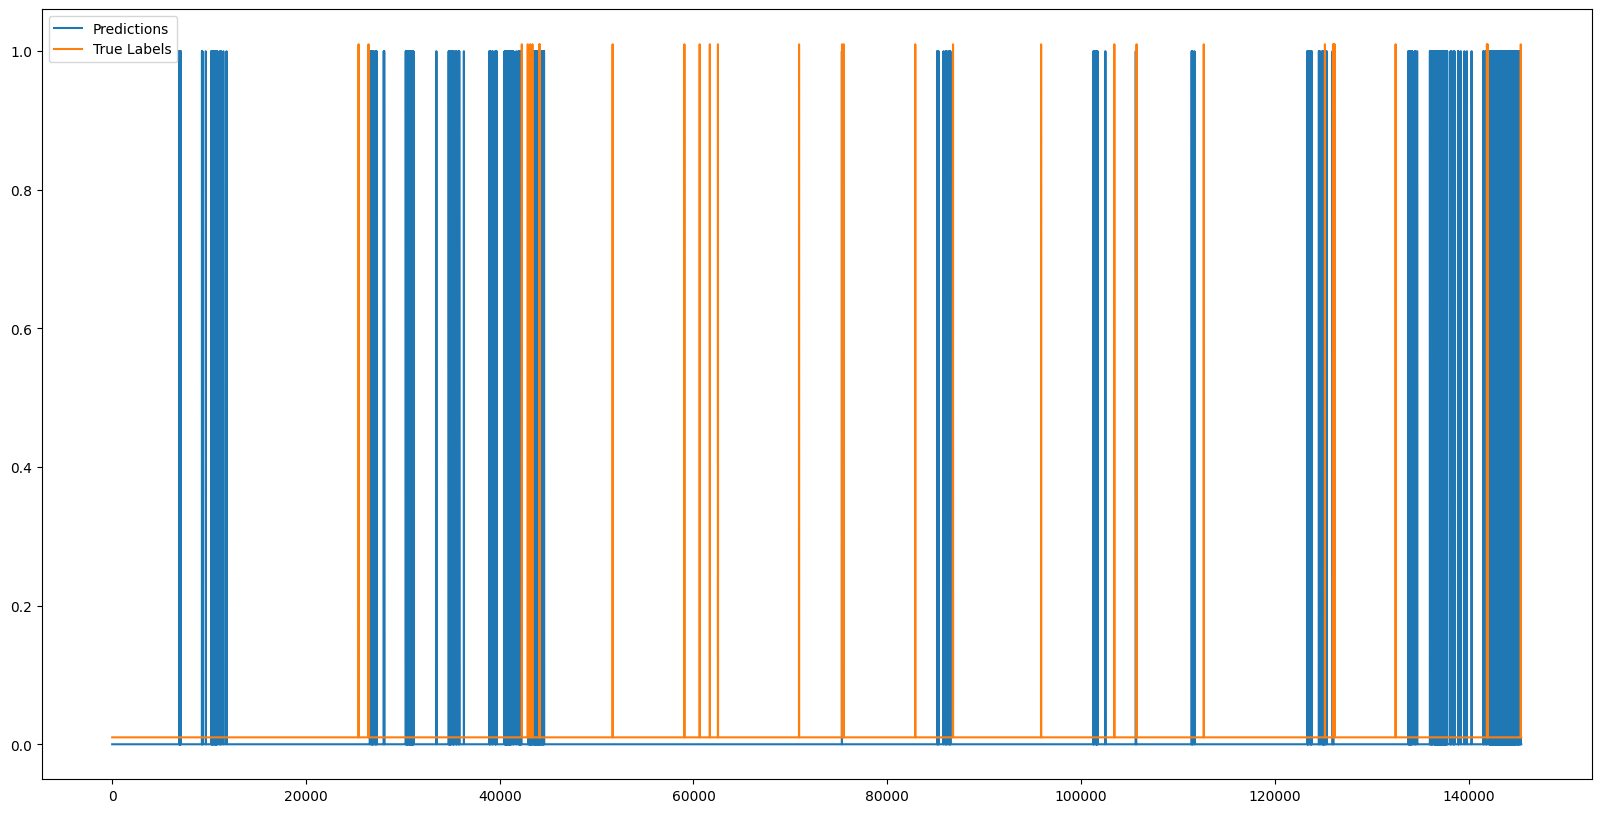

In [ ]:
plott = y_test.to_list()
plott = [i+0.01 for i in plott]

plt.figure(figsize=(20, 10))
plt.plot(y_pred, label='Predictions')
plt.plot(plott,label='True Labels')
plt.legend()
plt.show()

In [ ]:
# xgb = XGBClassifier(n_estimators=100, max_depth=10, random_state=0)
# xgb.fit(X_new, y_new)

# print('unsmoted')
# y_pred = xgb.predict(X_train)

# print(confusion_matrix(y_train, y_pred))
# print(classification_report(y_train, y_pred))


# print()
# y_pred = xgb.predict(X_test)

# print('test')
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [ ]:
# svc = SVC(kernel='rbf', random_state=0)
# svc.fit(X_new, y_new)

# y_pred = svc.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [ ]:
# ln = LogisticRegression(random_state=0, max_iter=1000)
# ln.fit(X_new, y_new)

# y_pred = ln.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_new, y_new)

# y_pred = knn.predict(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

### Make a true confusion matrix which takes in only the original labels, meaning put 1 to be when isrc failed. 
For the predictions it will assume tp only if withing a timewindow after the true value lays the actual failure

### Try scaling and normalizing

PDM from aircrafts lookup


# Random Forest With specialized predictions

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_new, y_new)

# y_pred = knn.predict(X_test)

# tr_pred = knn.predict(X_train)

# print("Unsmoted")
# print(confusion_matrix(y_train, tr_pred))
# print(classification_report(y_train, tr_pred))

# print()     

# print("Test")
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=-1)
rf.fit(X_new, y_new)

tr_pred = rf.predict(X_train)

y_pred = rf.predict(X_test)

print("Unsmoted")
print(confusion_matrix(y_train, tr_pred))
print(classification_report(y_train, tr_pred))

print()     

print("Test")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Unsmoted
[[739317  79341]
 [   546   3050]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    818658
           1       0.04      0.85      0.07      3596

    accuracy                           0.90    822254
   macro avg       0.52      0.88      0.51    822254
weighted avg       1.00      0.90      0.94    822254


Test
[[143787   1326]
 [   330      0]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    145113
           1       0.00      0.00      0.00       330

    accuracy                           0.99    145443
   macro avg       0.50      0.50      0.50    145443
weighted avg       1.00      0.99      0.99    145443



In [ ]:
import numpy as np
def collapse_consecutive_ones(true_labels, predicted_labels):
    collapsed_true_labels = []
    collapsed_predicted_labels = []

    i = 0
    while i < len(true_labels):
        if true_labels[i] == 1:
            j = i + 1
            while j < len(true_labels) and true_labels[j] == 1:
                j += 1
            collapsed_true_labels.append(1)
            collapsed_predicted_labels.append(1 if np.any(predicted_labels[i:j]) else 0)
            i = j
        else:
            collapsed_true_labels.append(true_labels[i])
            collapsed_predicted_labels.append(predicted_labels[i])
            i += 1

    return collapsed_true_labels, collapsed_predicted_labels

In [ ]:
test_list = y_test.to_list()


collapsd_true_labels, collapsed_predicted_labels = collapse_consecutive_ones(test_list, y_pred)



In [ ]:
print("Test")
print(confusion_matrix(collapsd_true_labels, collapsed_predicted_labels))
print(classification_report(collapsd_true_labels, collapsed_predicted_labels))

Test
[[143787   1326]
 [    30      0]]


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    145113
           1       0.00      0.00      0.00        30

    accuracy                           0.99    145143
   macro avg       0.50      0.50      0.50    145143
weighted avg       1.00      0.99      1.00    145143

